## Лабораторная работа 3 - Байесовская оптимизация

## Построение регрессии с помощью Гауссовского процесса

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sbs

### Генерация выборки

Ответ на очередном объекте $x_i$ генерируется следующим образом:

$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$

In [3]:
def f(x):
    return -8*np.sin(x)

support = np.arange(-1.0, 11.0, 1e-2)

In [4]:
X_train = np.arange(0,10.0,0.5)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train+2*np.random.randn(*X_train.shape)

X_test = support
X_test = X_test.reshape([len(X_test), -1])

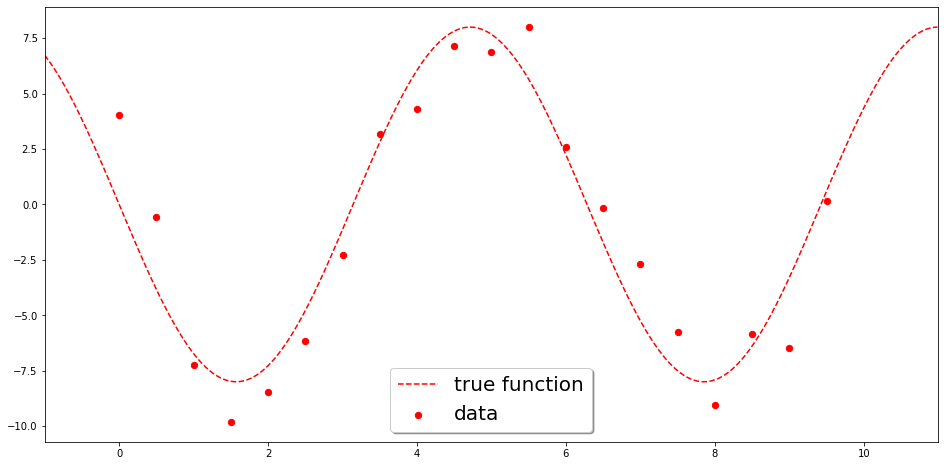

In [5]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

### Предсказание

В тестовой точке $x$ мы можем предсказать два параметра – мат. ожидание $\mu(x)$ и стандартное отклонение $\sigma(x)$.
Для заданной ковариационной функции $k(x,y)$ и для заданной дисперсии случайного шума $\beta^{-1}$, $\mu(x), \sigma(x)$ вычисляются по следующим формулам:

$$\mu(x) = \mathbf{k}^TC_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^TC_N^{-1}\mathbf{k},$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Примеры ковариационных функций:
- $K(x,y) = C$ – константная,
- $K(x,y) = \sum_{j=1}^d\theta_jx_jy_j$ – линейная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2)$  – экспоненциальная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j|x_j-y_j|)$ – процесс Орнштейна-Уленбека.

**1.** Реализуте функции вычисления ковариационных матриц между двумя произвольными выборками объектов, а затем функцию, вычисляющую предсказание в новой точке. Циклы использовать запрещено.

In [6]:
def linear_k(X, Y, theta):
    return (theta * (X * Y[:, np.newaxis])).sum(axis=2).T
    
def rbf_k(X, Y, theta):
    return np.exp(-(theta * (X - Y[:, np.newaxis]) ** 2).sum(axis=2).T)

def ou_k(X, Y, theta):
    return np.exp(-(theta * np.abs(X - Y[:, np.newaxis])).sum(axis=2).T)

def predict(X_train, T_train, X_test, theta, beta, kernel):
    K = kernel(X_train, X_train, theta)
    k = kernel(X_train, X_test, theta)

    C_N = K + 1/beta * np.eye(N=K.shape[0], M=K.shape[1])
    C_N_inv = np.linalg.inv(C_N)

    tmp = k.T @ C_N_inv

    mu_test = (tmp @ T_train).squeeze()
    sigma_test = np.diag(kernel(X_test, X_test, theta)) + 1/beta - np.diag(tmp @ k)

    return mu_test, sigma_test

In [7]:
def plot_result():
    figsize(16,8)
    plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    plt.plot(support, f(support), '--r', label='true function')
    plt.plot(X_test, mu_test, c='b', label='mu test')
    plt.fill_between(X_test.flatten(), mu_test-sigma_test, mu_test+sigma_test, color='b', label='confidence', alpha=0.3)
    plt.legend(fontsize=20, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

### Экспоненциальная ковариационная функция

In [8]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

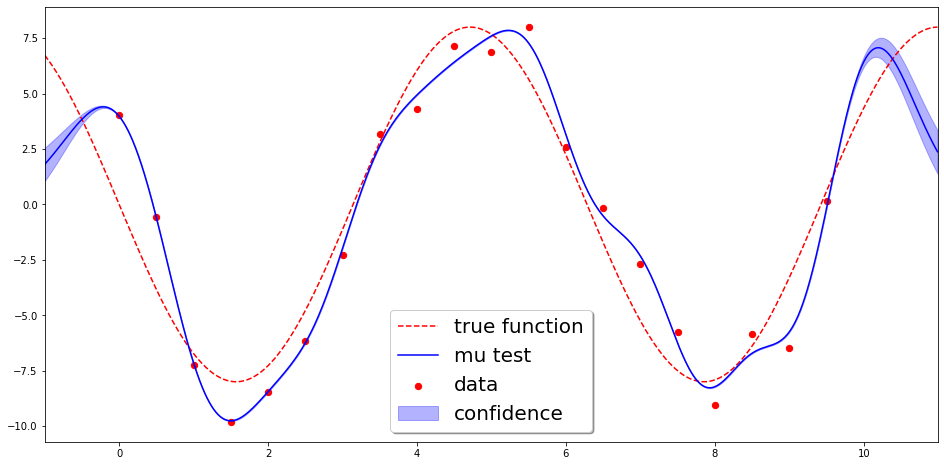

In [9]:
plot_result()

Посмотрим как ведёт себя регрессия для разных значений $\beta$

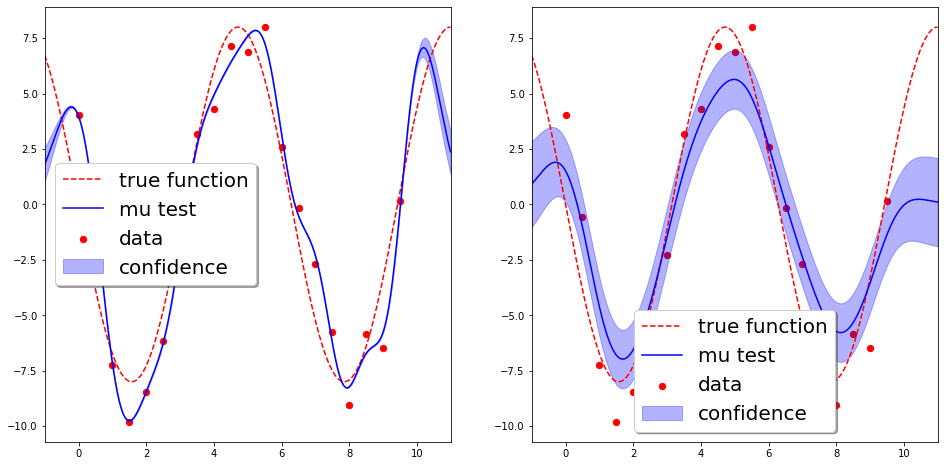

In [10]:
plt.subplot(121)
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()
plt.subplot(122)
theta = np.array([1.0])
beta = 1.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()

Запишите что вы пронаблюдали и как можно интерпретировать параметр $\beta$.  
(_пункт не оценивается_)

Можно заметить, что чем больше бета, тем более уверенный прогноз делает модель.

### Линейная ковариационная функция

In [11]:
theta = np.array([1.0])
beta = 100.0
kernel = linear_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

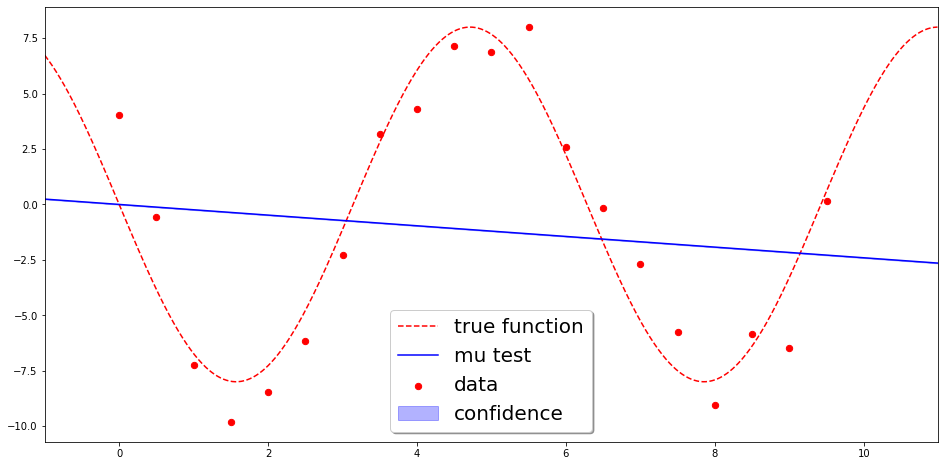

In [12]:
plot_result()

### Ковариационная функция Орнштейна-Уленбека

In [13]:
theta = np.array([1.0])
beta = 100.0
kernel = ou_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

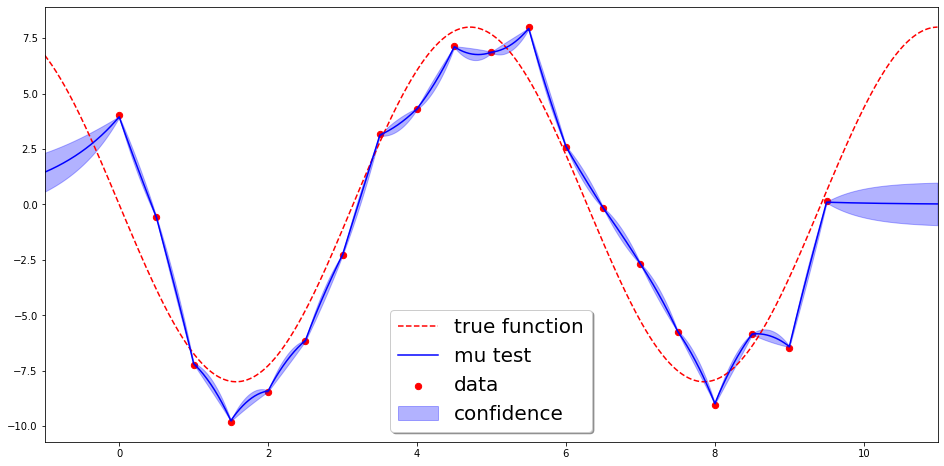

In [14]:
plot_result()

На практике часто прибегают к смеси ковариационных функций, чтобы добиться определённых свойств регрессии.

In [15]:
theta = np.array([1.0])
beta = 10.0
kernel = lambda X,Y,theta: ou_k(X,Y,theta) + rbf_k(X,Y,theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

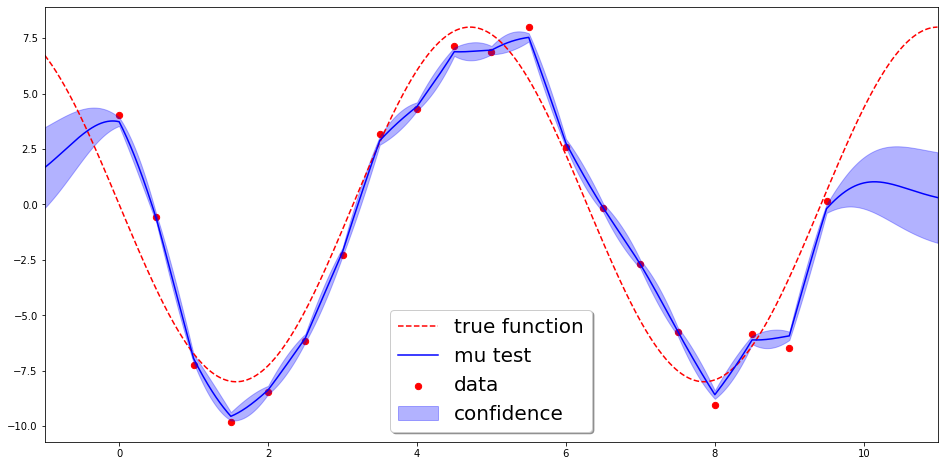

In [16]:
plot_result()

### Подбор параметров

Подбор параметров $\theta$ для произвольного ядра можно сделать максимизируя логарифм правдоподобия на обучающей выборке:

$$\log p(\mathbf{t}|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}\mathbf{t}^TC_N^{-1}\mathbf{t} - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$$

Максимизировать заданный функционал мы будем с помощью градиентного подъёма. Однако, мы будем проводить оптимизацию по $\log\theta$ (т.е. считать градиенты относительно $\log\theta$ и обновлять $\log\theta$, а не сами $\theta$), поскольку так процесс проще сходится

Вам пригодится формула для градиента по $\theta$:

$$\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}\mathbf{t}$$

**2.** 

  а) Получите формулу для расчёта градиента логарифма правдоподобия по $\log\theta$ 

  б) Реализуйте функцию для расчёта градиента логарифма правдоподобия по $\log\theta$ а также функцию для расчёта правдоподобия. Ядро – RBF.

а)
Из формулы выше $\implies$
$$\frac{\partial}{\partial \log\theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \log\theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \log\theta_j}C_N^{-1}\mathbf{t}$$

$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$

В данном случае $\mathbf{K}_{ij} = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2) = \exp(-\sum_{j=1}^d\exp\left(\log\theta_j\right)(x_j-y_j)^2)$

Тогда:

$$ \frac{\partial C_N}{\partial \log\theta_j} = \frac{\partial \mathbf{K}}{\partial \log\theta_j} = \mathbf{K} \frac{\partial}{\partial \log\theta_j}\left(-\sum_{j=1}^d\exp\left(\log\theta_j\right)(x_j-y_j)^2 \right) = - \mathbf{K} \theta_j \left(x_j - y_j\right)^2 $$



In [17]:
def get_rbf_grad_log_theta(X, Y, theta, beta):
    K = rbf_k(X, X, theta)

    C_N = K + 1/beta * np.eye(N=K.shape[0], M=K.shape[1])
    C_N_inv = np.linalg.inv(C_N)

    dC_N = - K * theta * (X - X[:, np.newaxis]).squeeze().T ** 2
    
    tmp = C_N_inv @ dC_N

    return -1/2 * np.trace(tmp) + 1/2 * Y.T @ tmp @ C_N_inv @ Y

def get_log_likelihood(X, Y, theta, beta):
    K = rbf_k(X, X, theta)

    C_N = K + 1/beta * np.eye(N=K.shape[0], M=K.shape[1])
    C_N_inv = np.linalg.inv(C_N)

    N = X.shape[0]

    return -1/2 * np.log(np.linalg.det(C_N)) - 1/2 * Y.T @ C_N_inv @ Y - N/2 * np.log(2 * np.pi)

In [18]:
lr = 1e-3
num_iterations = 100
beta = 100.0
log_theta = np.log(np.array([10.0]))
log_likelihood = np.zeros(num_iterations)
theta_history = np.zeros(num_iterations)
for i in range(num_iterations):
    theta_history[i] = np.exp(log_theta)
    log_theta = log_theta + lr*get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
    log_likelihood[i] = get_log_likelihood(X_train, T_train, np.exp(log_theta), beta)

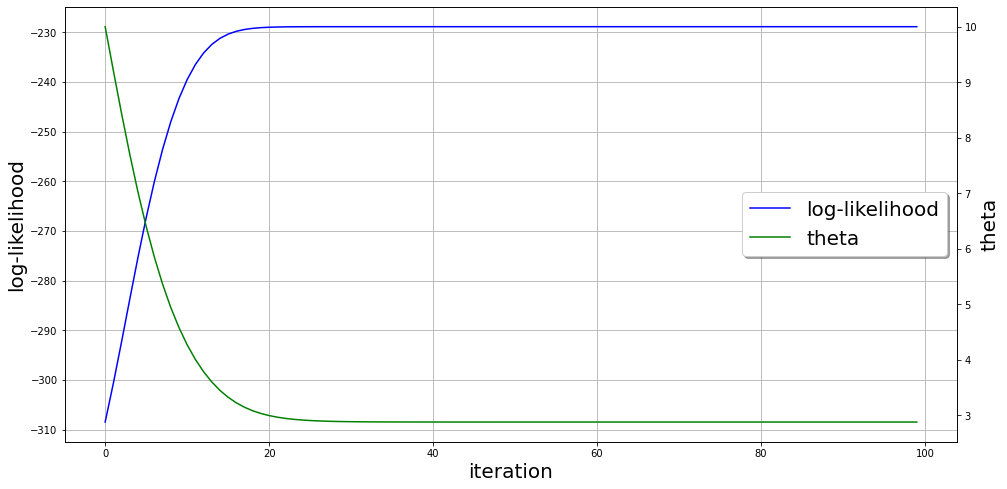

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(log_likelihood, label='log-likelihood', c='b')
ax1.set_xlabel('iteration', fontsize=20)
ax1.set_ylabel('log-likelihood', fontsize=20)
ax1.grid()

ax2.plot(theta_history, label='theta', c='g')
ax2.set_ylabel('theta', fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, fontsize=20, loc='center right', frameon=True, shadow=True)
plt.show()

In [20]:
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)

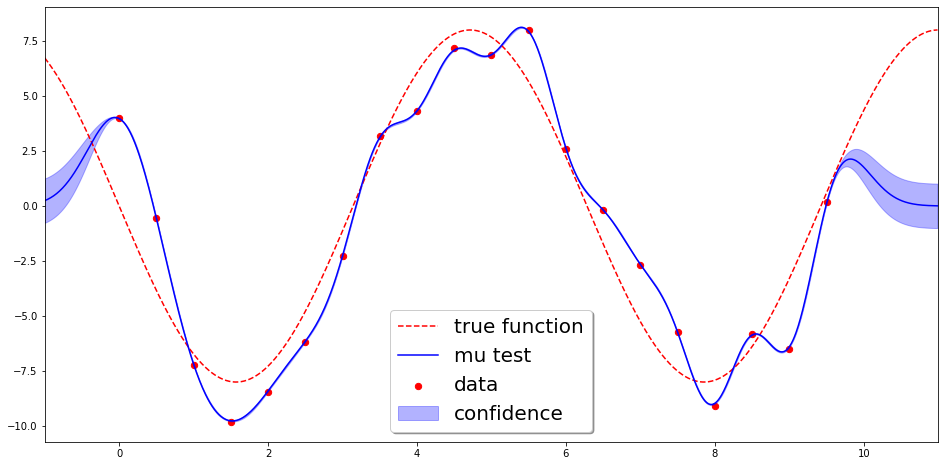

In [21]:
plot_result()

Сравните этот график с графиком для $\theta=1$. Что произошло с мат. ожиданием? Как изменился параметр $\theta$?  
(_пункт не оценивается_)

В данном случае линия проходит идеально по тренироворчным данным. Параметр $\theta$ стал чуть больше 2, то есть увеличился.

## Оптимизация с помощью Гауссовского процесса

С помощью Гауссовского процесса можно решать задачи black-box оптимизации. То есть, оптимизировать функцию, вид которой нам не известен и нет никакой дополнительной информации, кроме её значений в некоторых точках. Такой метод оптимизации может использоваться для поиска экстремумов некоторой функции, которую очень дорого вычислять, а градиенты этой функции мы и вовсе не можем рассчитать.

Концепция такого алгоритма оптимизации следующая:
1. Настраиваем параметры Гауссовского процесса для имеющегося набора точек.
2. В каждой точке пространства $x$ мы можем посчитать величину expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)),$$
где $t_{\min}$ – минимальное значение целевой переменной на уже имеющейся выборке.  
На практике же, мы не можем посчитать expected improvement в каждой точке пространства, но мы можем оптимизировать эту функцию относительно $x$ методами первого или второго порядка и найти локальный максимум этой функции.
3. В качестве новой точки выбираем $x^* = \text{argmax}\; \text{EI}(x)$ и рассчитываем значение $t^*$ в этой точке. После чего добавляем эту точку к нашим данным и возвращаемся к шагу 1.

Сгенерируем выборку

In [22]:
def f(x):
    return -1/np.sqrt(2*np.pi*0.25)*np.exp(-0.5/0.09*(x-4)**2)-1/np.sqrt(2*np.pi*1.0)*np.exp(-0.5/1.0*(x-8)**2)

support = np.arange(0.95,11.1,1e-2)

In [23]:
X_train = np.arange(2.0,10.0,3.0)
X_train = X_train + (2.*np.random.rand(len(X_train))-1.)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train

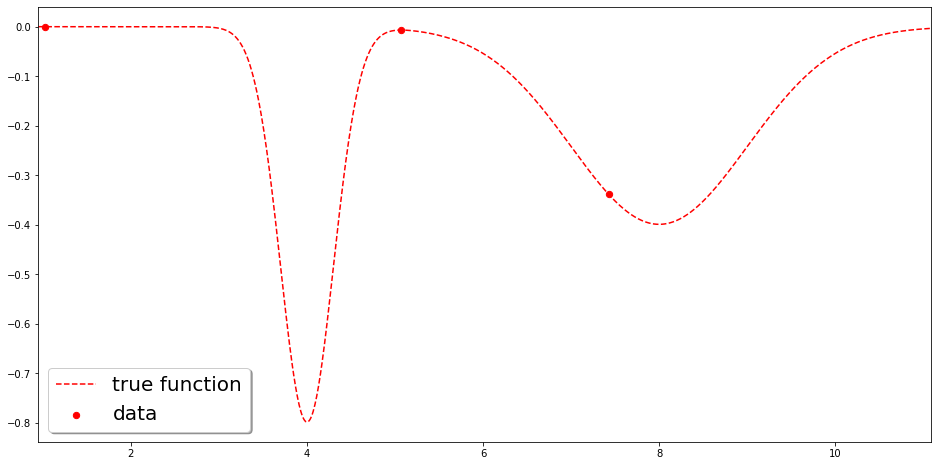

In [24]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

**3.** Выведите формулу для expected improvement.

$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)) = \mathbb{E}_{y(x)}\left[\left(t_{\min} - y(x)\right) \mathbb{I}\left[t_{min} > y(x)\right] \right] =  \mathbb{E}_{y(x)}\left[t_{\min} \mathbb{I}\left[t_{min} > y(x)\right] \right] - \mathbb{E}_{y(x)}\left[y(x)\mathbb{I}\left[t_{min} > y(x)\right] \right] = t_{min} \mathbb{P}\left(t_{min} > y(x)\right) - \mathbb{E}_{y(x)}\left[\mathcal{N}(y(x)|\mu(x), \sigma^2(x))\mid t_{min} > y(x) \right] \mathbb{P}\left(t_{min} > y(x)\right) = \mathbb{P}\left(t_{min} > y(x)\right) \left(t_{min} - \mathbb{E}_{y(x)}\left[\mathcal{N}(y(x)|\mu(x), \sigma^2(x))\mid t_{min} > y(x) \right]\right)$$

Рассмотрим случай, когда $y(x) \sim \mathcal{N}(y(x)|0, 1)$. Общий случай сводится к этому путём замены $y(x) := \mu(x) + y(x)\sigma(x)$.

Заметим, что для плотности нормального распределения выполняется $p'(z) = -zp(z) \quad (*)$

Имеем:
$$\mathbb{E}_{y(x)}\left[\mathcal{N}(y(x)|0, 1)\mid t_{min} > y(x) \right] = \frac{\int_{-\infty}^{t_{min}} zp(z)dz}{\mathbb{P}\left(t_{min} > y(x)\right)} = \left\{*\right\}= -\frac{p(t_{min})}{\mathbb{P}\left(t_{min} > y(x)\right)}$$

Тогда:

$$\mathbb{E}_{y(x)}\left[\mathcal{N}(y(x)|\mu(x), \sigma^2(x))\mid t_{min} > y(x) \right] = -\frac{p\left(\frac{t_{min} - \mu(x)}{\sigma(x)}\right)}{\mathbb{P}\left(\frac{t_{min} - \mu(x)}{\sigma(x)} > y(x)\right)}\sigma(x) + \mu(x) $$


**4.** Реализуйте функцию для расчёта expected improvement.

In [31]:
from scipy import stats

def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    t_min = T_train.min()

    mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

    P_tmin = stats.norm.cdf(np.full_like(mu_test, t_min), mu_test, sigma_test)

    return P_tmin * (t_min + stats.norm.pdf((t_min - mu_test) / sigma_test, 0, 1) / P_tmin * sigma_test - mu_test)

In [32]:
X_test = support
X_test = X_test.reshape([len(X_test), -1])

In [33]:
def plot_expected_improvement(X_train, T_train, expected_improvement, predictions, sigma):
    fig, ax1 = plt.subplots(1,1)
    ax2 = ax1.twinx()

    ax1.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    ax1.plot(support, predictions, label='mean')
    ax1.fill_between(support, predictions-sigma, predictions+sigma, color='b', alpha=0.3, label='uncertainty')
    ax1.plot(support, f(support), '--r', label='true function')
    ax1.grid()

    ax2.plot(support, expected_improvement, label='Expected improvement', c='g')
    ax2.scatter(support[np.argmax(expected_improvement)], np.max(expected_improvement), label='max', c='g', s=40)
    ax2.set_ylabel('Expected improvement', fontsize=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, fontsize=10, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

In [34]:
import time
from IPython import display

Запустите процесс оптимизации. Сошёлся ли он в точку минимума? Попробуйте разные значения параметров.  
(_пункт не оценивается_)

Да, сошелся

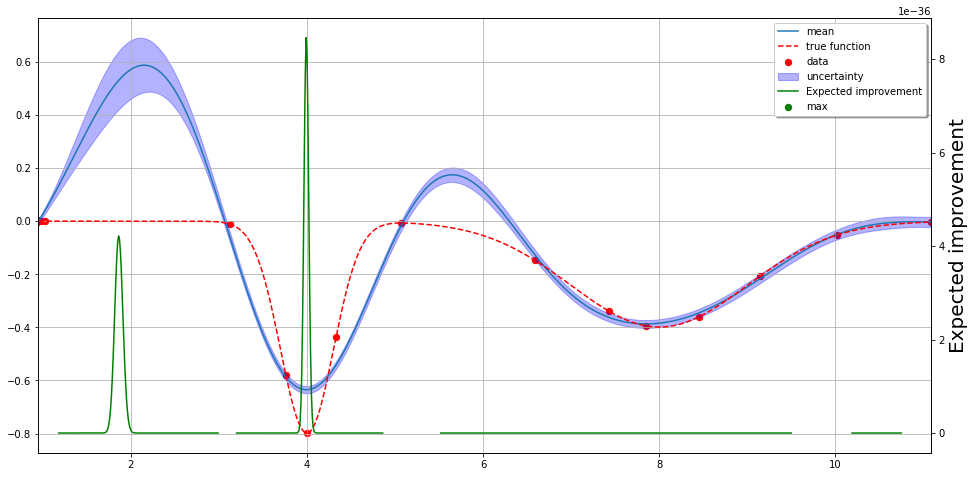

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [35]:
beta = 100.0
num_tuning_steps = 500
num_new_points = 30
lr = 1e-2
for _ in range(num_new_points):
    plt.clf()
    # model tuning  
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    mu, sigma = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    plot_expected_improvement(X_train, T_train, expected_improvement, mu, sigma)
    # adding new point
    X_train = np.vstack([X_train, np.array(support[np.argmax(expected_improvement)])])
    T_train = f(X_train)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
_ = plt.clf()